# Standard Kalman Filter

The current state can be calculated from the last state, the controls and process noise.\
$x_{n} = \boldsymbol{F}_{n}x_{n-1} + \boldsymbol{B}_{n}u_{n} + w_{n}$

The observation of the state can be calculated from the current state and observation noise.\
$z_{n} = \boldsymbol{H}_{n}x_{n}+ v_{n}$

## Predict the next State
Prior of the state\
$\hat{x}_{n|n-1} = \boldsymbol{F}_{n}\hat{x}_{n-1|n-1} + \boldsymbol{B}_{n}u_{n}$

Priori covariance\
$\boldsymbol{P}_{n|n-1} = \boldsymbol{F}_{n}\boldsymbol{P}_{n-1|n-1}\boldsymbol{F}_{n}^{\mathsf{T}} + \boldsymbol{Q}_{n}$

## Update the State given observations

Innovation pre-fit Residual\
$\tilde{y}_{k} = z_{n} - \boldsymbol{H}_{n}\hat{x}_{n|n-1}$

Innovation Covariance\
$\boldsymbol{S}_{n} =  \boldsymbol{H}_{n}\boldsymbol{P}_{n|n-1}\boldsymbol{H}_{n}^{\mathsf{T}} + \boldsymbol{R}_{n}$

Kalman gain\
$\boldsymbol{K}_{n} = \boldsymbol{P}_{n|n-1}\boldsymbol{H}_{n}^{\mathsf{T}}\boldsymbol{S}_{n}^{-1}$

State estimate\
$\hat{x}_{n|n} = \hat{x}_{n|n-1} + \boldsymbol{K}_{n}\tilde{y}_{n}$

Estimate Covariance\
$\boldsymbol{P}_{n|n} = (\boldsymbol{I} - \boldsymbol{K}_{n} \boldsymbol{H}_{n}) \boldsymbol{P}_{n|n-1}$


The following libraries will be used, in this project.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from math import sin, cos, radians, pi, sqrt
from Graph_functions import *
from helper_functions import *

# Satellite Navigation
The first example will be a satellite orbiting earth, will assume the satellite is only moving in two dimension $x_{1}$ and $x_{2}$. \
Model a Satellite that should have a circular orbit.\
But assume the satellite randomly moves from unknown causes, that are drawn from a gaussian distribution with variance $Q_{t}$ at time t.\
Can measure the distance to the satellite in the $x_{1}$, want to accurately estimate the $x_{2}$ measurement.\
Assume the measurements of $x_{1}$ is also gaussian distributed, with variance $R_{t}$ at time t.




The following equation comes from rotating the 2d plane by $a$ degrees anti-clockwise.

\begin{align}
\boldsymbol{X}_{t+1} &= \begin{pmatrix} x_{1}(t+1) \\ x_{2}(t+1) \end{pmatrix} \\
&= \begin{pmatrix} cos(at) & sin(at) \\ sin(at) & -cos(at) \end{pmatrix} \begin{pmatrix} x_{1}(t) \\ x_{2}(t) \end{pmatrix}
\end{align}


Taking derivatives gives
\begin{align}
\boldsymbol{\dot{X}}_{t} &= \begin{pmatrix} \dot{x}_{1}(t) \\ \dot{x}_{2}(t) \end{pmatrix} \\
&= \begin{pmatrix} 0 & -a \\ a & 0\end{pmatrix} \begin{pmatrix} x_{1}(t) \\ x_{2}(t) \end{pmatrix} \\
&= \begin{pmatrix} 0 & -a \\ a & 0\end{pmatrix} \boldsymbol{X}_{t}
\end{align}


Using Euler method\
\begin{align}
h &= t_{n+1} - t_{n} \\
\boldsymbol{X}_{t+1} &= \boldsymbol{X}_{t}+h\boldsymbol{\dot{X}}_{t}
\end{align}


Subbing $\boldsymbol{\dot{X}}_{t}$ in

\begin{align}
\boldsymbol{X}_{t+1} &= \boldsymbol{X}_{t} + \begin{pmatrix} 0 & -a \\ a & 0 \end{pmatrix}\boldsymbol{X}_{t}h \\
  &= \begin{pmatrix} 1 & -ha \\ ha & 1 \end{pmatrix}\boldsymbol{X}_{t}
\end{align}

Thus
$$
\boldsymbol{F}_{n} = \begin{pmatrix} 1 & -ha \\ ha & 1 \end{pmatrix}
$$

Create a satellite object


In [2]:
class Satellite:

    def __init__(self, a=1, h=1, q=0, r=0, radius=10, start_angle=None):
        self.a = a
        self.h = h
        self.radius = radius
        self.r = r
        self.q = q
        self.x1 = []
        self.x2 = []
        self.times = []
        self.measurements_times = []
        self.current_time = 0
        self.start_angle = start_angle
        self.measurements = []

    def __random_start__(self):
        #returns a random start cords for both x1 and x2
        #if they are not given
        if self.start_angle is None:
            self.start_angle = np.random.uniform(2 * pi)

        x1_cord = self.radius * cos(self.start_angle)
        x2_cord = self.radius * sin(self.start_angle)
        return x1_cord, x2_cord

    def next_cord(self, receive=True):
        self.times.append(self.current_time)

        if len(self.x1) == 0:
            x1_cord, x2_cord = self.__random_start__()
            self.x1.append(x1_cord)
            self.x2.append(x2_cord)

            x1_measurement = x1_cord + np.random.normal(0, self.r)
            self.measurements.append(x1_measurement)
            self.measurements_times.append(self.current_time)

            self.current_time += self.h
            return x1_measurement

        trans_matrix = np.array([[cos(self.a * self.h), -sin(self.a * self.h)], [sin(self.a * self.h), cos(self.a * self.h)]])
        last_cords = np.array([self.x1[-1], self.x2[-1]])

        cords = np.dot(trans_matrix, last_cords)
        x1_cord, x2_cord = cords
        x1_noise, x2_noise = np.random.normal(0, self.q, 2)
        x1_cord += x1_noise
        x2_cord += x2_noise

        self.x1.append(x1_cord)
        self.x2.append(x2_cord)

        if receive:
            x1_measurement = x1_cord + np.random.normal(0, self.r)
            self.measurements.append(x1_measurement)
            self.measurements_times.append(self.current_time)
        else:
            x1_measurement = None

        self.current_time += self.h
        return x1_measurement if receive else None

    def graph(self, show=True):
        #graphs x1, x2 true cords and the measurement of x1
        plt.title('Dimensions X1, X2 and X2 measurements of the satellite over time')
        plt.plot(self.measurements_times, self.measurements, '.', label='Measurements')
        plt.plot(self.times, self.x1, label='x1')
        plt.plot(self.times, self.x2, label='x2')
        if show:
            plt.legend()
            plt.show()

### Code for the Kalman Filter
Create the Kalman Filter

In [3]:
class KalmanFilter(object):
    def __init__(self, f, h, q, r, p, x, b=0, u=0):
        self.f = f
        self.h = h
        self.q = q
        self.r = r
        self.p = p
        self.x = x
        self.b = b
        self.u = u
        self.n = f.shape[1]

    def predict(self):
        self.x = np.dot(self.f, self.x) + np.dot(self.b, self.u)
        self.p = np.dot(np.dot(self.f, self.p), self.f.T) + self.q
        return self.x

    def update(self, z):
        y = z - np.dot(self.h, self.x)
        s = np.dot(np.dot(self.h, self.p), self.h.T) + self.r
        k = np.dot(np.dot(self.p, self.h.T), np.linalg.inv(s))
        self.x = self.x + np.dot(k,y)
        self.p = np.dot(np.identity(len(self.x)) - np.dot(k, self.h), self.p)
        return self.x

### Average Error
To calculate the average error of the estimates, need to calculate the average error at each time step.\
We have the average from the last time step, so will use this to save computation.



\begin{align}
 \bar{x}_{n} &=  \frac{\displaystyle \sum_{i=1}^{n}x_{i}}{n} \\
 &= \frac{\displaystyle \sum_{i=1}^{n-1}x_{i}}{n} + \frac{x_{n}}{n} \\
 &= \frac{n-1}{n}\frac{\displaystyle \sum_{i=1}^{n-1}x_{i}}{n-1} + \frac{x_{n}}{n} \\
 &= \frac{1}{n}[(n-1)\bar{x}_{n-1}+x_{n}]
\end{align}




In [4]:
def average(x, n, a):
    #computes an average from last average a and n indexed at 0 for next item x
    return (n * a + x) / (n + 1)

### Satellite example
Now have everything to create a satellite and run the Kalman filter. \
The initial estimate is (0,0) with a variance of the radius.

In [5]:
def satellite_example(h, a, r, q, radius, revolutions, receive_function):

    loop_count = loop_size(h, a, revolutions)

    X = np.array([0,0])
    F = np.array([[1, -a * h], [h * a, 1]])
    H = np.array([1, 0]).reshape(1, 2)
    Q = np.array([[q, 0], [0, q]])
    R = np.array([r]).reshape(1, 1)
    P = np.array([[radius, 0], [0, radius]])

    kf = KalmanFilter(f=F, h=H, q=Q, r=R, x=X, p=P)
    satellite = Satellite(a=a, h=h, q=q, r=r, radius=radius)

    prediction_data = []
    estimate_data = []

    for i in range(loop_count):
        receive = receive_function(i)

        z = satellite.next_cord(receive=receive)

        x1, x2 = kf.predict()
        prediction_data.append((x1, x2, kf.p))

        if z is not None:
            x1, x2 = kf.update(z)
            estimate_data.append((x1, x2, kf.p))

    return satellite, prediction_data, estimate_data

In [6]:
h = 10
a = (pi * 2) / 360
r = 2
q = 0.1
radius = 10
revolutions = 1.5
receive_function = always_true

satellite, prediction_data, estimate_data = satellite_example(h, a, r, q, radius, revolutions, receive_function)

### Satellite movement
View how the satellite is moving in time and what measurements are being observed.

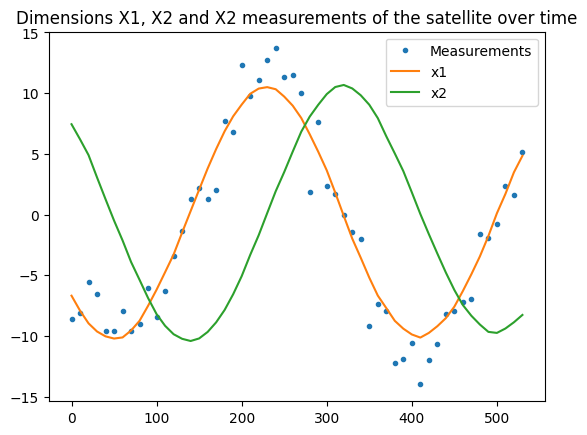

In [7]:
satellite.graph()

### $x_{1}$ Dimension
The real $x_{1}$ path vs the $x_{1}$ estimate path.\
The measurements and predictions are also included.

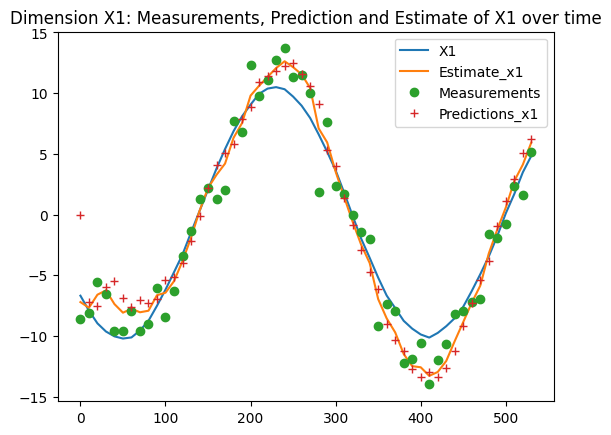

In [8]:
graph_x1(satellite, prediction_data, estimate_data)

### $x_{2}$ Dimension
The real $x_{2}$ path vs the $x_{2}$ estimate path. \
The predictions are also included.

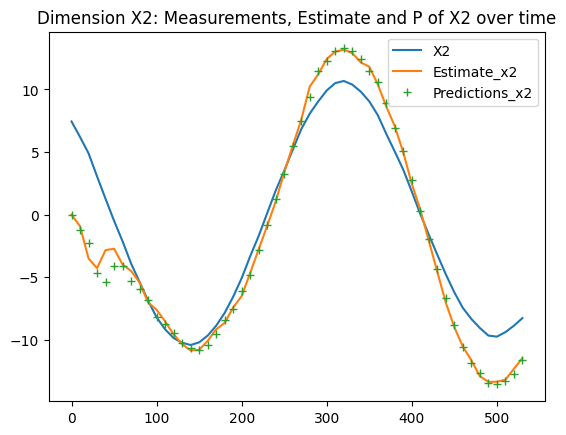

In [9]:
graph_x2(satellite, prediction_data, estimate_data)

###Error
Error of the $x_{1}$, $x_{2}$ Estimates\
Vs\
Error of the Measurements

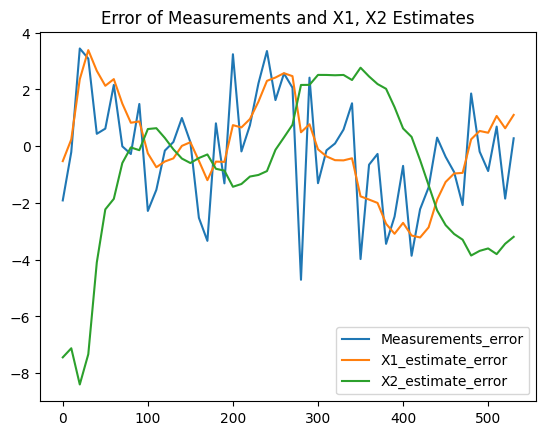

In [10]:
graph_error(satellite, prediction_data, estimate_data)

###Average Error
The average absolute error of the $x_{1}$, $x_{1}$ Estimates\
Vs\
The average absolute error of the Measurements

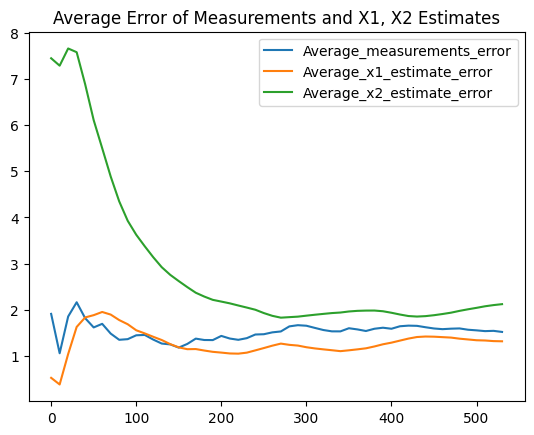

In [11]:
graph_average_error(satellite, prediction_data, estimate_data)

# Unreliable observations of Measurements
It is not realistic to assume every $h$ seconds a new measurement will be available to use. \
Can change this, by changing the receive_function. \
If the functions returns $True$ a new measurement will be observed, the Kalman filter will continue as before. \
If the function returns $False$, the Kalman filter will run the predict step but not the update step.

###Create two Satellites with unreliable observations
One will observe a measurement for 3 consecutive time steps, then miss 1 time step and repeat.\
The other will observe a measure every time step 75% of the time. \
Will reduce r to 0.5 from 2, so the affect is clearly visible.

In [12]:
def chance_of_75_percent(i):
    return np.random.randint(4) != 0

def every_third_removed(i):
    return i % 4 != 0
r = 0.5

receive_function = chance_of_75_percent
satellite_1 = satellite_example(h, a, r, q, radius, revolutions, receive_function)
receive_function = every_third_removed
satellite_2 = satellite_example(h, a, r, q, radius, revolutions, receive_function)



The first graph is the satellite with a 75% chance of observing a measurement every time step.

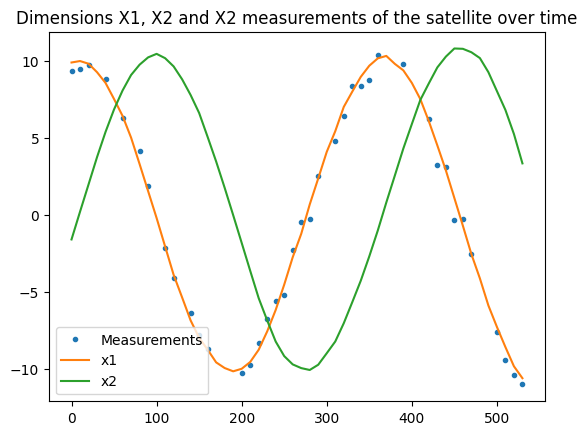

In [13]:
satellite_1[0].graph()

The next graph is the satellite that observes 3 consecutive time steps, then misses 1 time step.

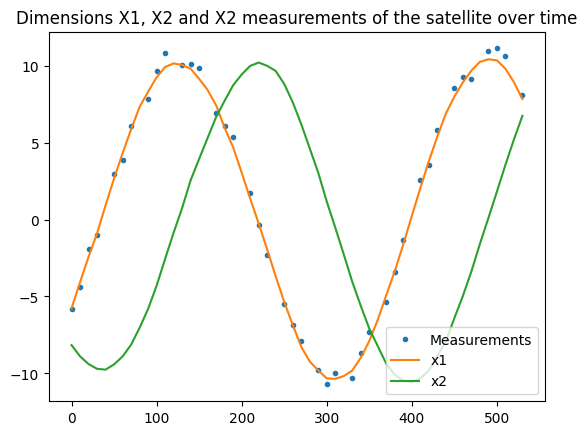

In [14]:
satellite_2[0].graph()

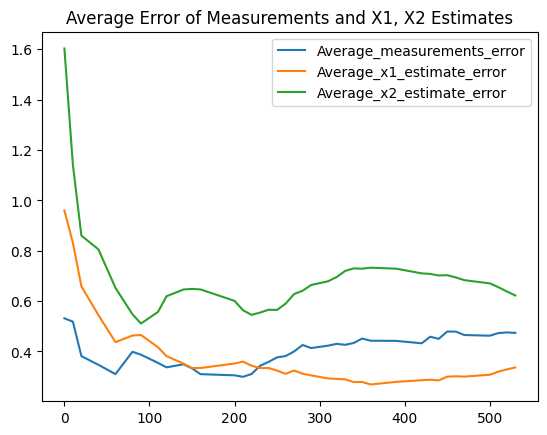

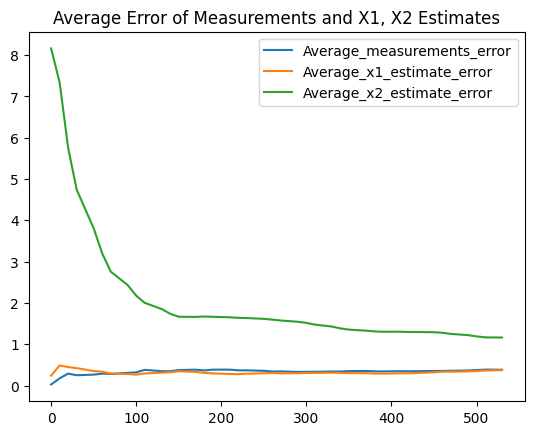

In [15]:

graph_average_error(satellite_1[0], satellite_1[1], satellite_1[2])
graph_average_error(satellite_2[0], satellite_2[1], satellite_2[2])

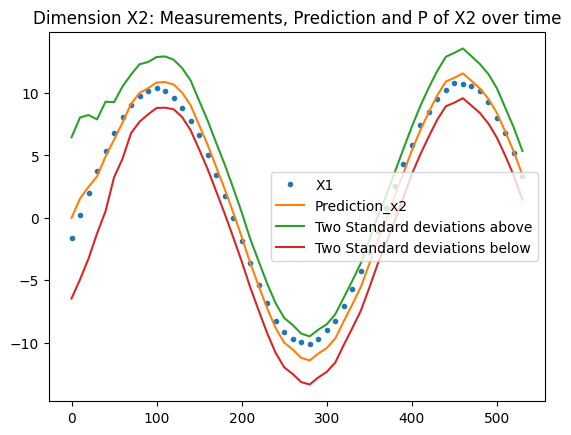

In [16]:
graph_x2_and_p(satellite_1[0], satellite_1[1], satellite_1[2])

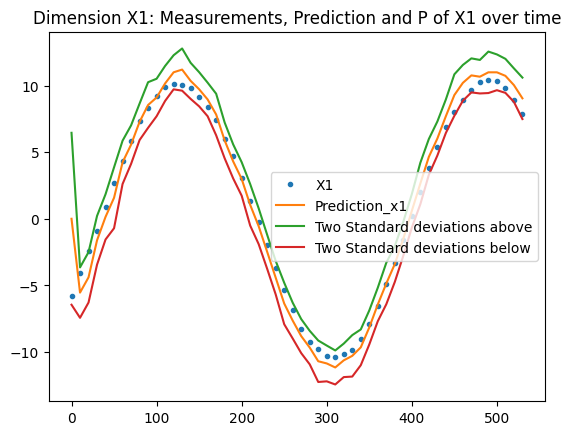

In [17]:
graph_x1_and_p(satellite_2[0], satellite_2[1], satellite_2[2])
